# FISH - Pipeline - A Python interactive notebook to process FISH data

```
Author: Luis U. Aguilera
Contact Info: luis.aguilera@colostate.edu

Copyright (c) 2021 Munsky Group 
Colorado State University 
Licensed under BSD 3-Clause License.
```

### Notebook summary 


- Load a directory with microscope FISH images
- Establish a connection to Network-attached storage (NAS) using [pysmb](https://github.com/miketeo/pysmb)
- Perform cell segmentation using [Cellpose](https://github.com/MouseLand/cellpose)
- Perform spot detection using [Big-FISH](https://github.com/fish-quant/big-fish)
- Datamanagement using Pandas

----

### Libraries

In [1]:
# Importing libraries
import sys
import pathlib
import warnings
import numpy as np
warnings.filterwarnings("ignore")

### Path to source directories

In [2]:
# Defining directories
current_dir = pathlib.Path().absolute()
fa_dir = current_dir.parents[0].joinpath('src')

# Importing fish_analyses module
sys.path.append(str(fa_dir))
import fish_analyses as fa

In [3]:
fa.Banner().print_banner()

 
FISH processing repository by : 
Luis U. Aguilera, Joshua Cook, Tim Stasevich, and Brian Munsky. 
 ____________________________________________________________  
|                      ,#^^^^^^^%&&&                         | 
|  .&.                 &.           ,&&&___                  | 
|  &  &         ___&&&/                    (&&&&____         | 
|  &    &,____#&                   .       #.       %&**,    | 
|  /(                  &         ,%       &       %     ,&   | 
|    &          &.                       %.      %&%     &*  | 
|     &&         *         .%            &             &(    | 
|   &                &(           ,#     .%             ,.&  | 
|  &    _&&__#&.     &&           &.      ,&         ,%&     | 
|  &  (%        #&,___                      (-***%&%^        | 
|  & &                %&&&(,.      .*#&&&&&%.                | 
|                          &    ,%%%%                        | 
|___________________________/%%^_____________________________| 



----

# Parameters defined by the user 

----

### Paths to images

In [4]:
# Path to credentials
desktop_path = pathlib.Path.home()/'Desktop'
path_to_config_file = desktop_path.joinpath('config.yml')
# Path to images and masks
path_to_masks_dir = None 

In [5]:
data_folder_path =pathlib.Path('smFISH_images/Sawyer_smFISH_images/A549/Terminator/20230425_DUSP1_A549_DEX_0min_031123')
data_folder_path =pathlib.Path('smFISH_images/Sawyer_smFISH_images/A549/Terminator/20230425_DUSP1_A549_DEX_10min_031123')
data_folder_path =pathlib.Path('smFISH_images/Sawyer_smFISH_images/A549/Terminator/20230425_DUSP1_A549_DEX_20min_031123')
data_folder_path =pathlib.Path('smFISH_images/Sawyer_smFISH_images/A549/Terminator/20230425_DUSP1_A549_DEX_30min_031123')
data_folder_path =pathlib.Path('smFISH_images/Sawyer_smFISH_images/A549/Terminator/20230425_DUSP1_A549_DEX_40min_031123')
data_folder_path =pathlib.Path('smFISH_images/Sawyer_smFISH_images/A549/Terminator/20230425_DUSP1_A549_DEX_50min_031123')
data_folder_path =pathlib.Path('smFISH_images/Sawyer_smFISH_images/A549/Terminator/20230425_DUSP1_A549_DEX_60min_031123')
data_folder_path =pathlib.Path('smFISH_images/Sawyer_smFISH_images/A549/Terminator/20230426_DUSP1_A549_DEX_75min_031123')
data_folder_path =pathlib.Path('smFISH_images/Sawyer_smFISH_images/A549/Terminator/20230426_DUSP1_A549_DEX_90min_031123')
data_folder_path =pathlib.Path('smFISH_images/Sawyer_smFISH_images/A549/Terminator/20230426_DUSP1_A549_DEX_120min_031123')
data_folder_path =pathlib.Path('smFISH_images/Sawyer_smFISH_images/A549/Terminator/20230426_DUSP1_A549_DEX_150min_031123')
data_folder_path =pathlib.Path('smFISH_images/Sawyer_smFISH_images/A549/Terminator/20230426_DUSP1_A549_DEX_180min_031123')

In [6]:
#data_folder_path =pathlib.Path('smFISH_images/Sawyer_smFISH_images/A549/Terminator/20230425_DUSP1_A549_DEX_0min_031123')
#data_folder_path =pathlib.Path('smFISH_images/Sawyer_smFISH_images/A549/Terminator/20230425_DUSP1_A549_DEX_10min_031123')
data_folder_path =pathlib.Path('TermData/data/users/Eric/DUSP1_smFISH/20230414_DUSP1_10nM_Dex_180min_040523_60x/20230414_5')
#data_folder_path =pathlib.Path('smFISH_images/Sawyer_smFISH_images/A549/Terminator/20230425_DUSP1_A549_DEX_30min_031123')



### Parameters for segmentation and spot detection

In [7]:
convert_to_standard_format = True
send_data_to_NAS=0                           # If data sent back to NAS use 1
download_data_from_NAS=1                     # If data downloaded from NAS use 1

In [8]:
diameter_nucleus=100                          # Approximate nucleus size in pixels
diameter_cytosol=215                          # Approximate cytosol size in pixels
voxel_size_z=500                              # Microscope conversion px to nanometers in the z axis.
voxel_size_yx=96#96                           # Microscope conversion px to nanometers in the xy axis.
psf_z=350                                     # Theoretical size of the PSF emitted by a [rna] spot in the z plan, in nanometers
psf_yx= int(voxel_size_yx*1.5)#96             # Theoretical size of the PSF emitted by a [rna] spot in the yx plan, in nanometers
channels_with_nucleus=None #[1]               # Channel to pass to python for nucleus segmentation
channels_with_cytosol=[1]                     # Channel to pass to python for cytosol segmentation
channels_with_FISH=[0]                        # Channel to pass to python for spot detection
optimization_segmentation_method ='default'   # optimization_segmentation_method = 'intensity_segmentation' 'z_slice_segmentation', 'z_slice_segmentation_marker', 'gaussian_filter_segmentation' , None
save_all_images = 0                           # To save all images for all the z-slices
save_filtered_images = False                  # To save filtered images.
number_of_images_to_process = None#           # Use an integer to process a subset of images. None is used to indicate that all images need to be processed.
minimum_spots_cluster = 2                     # Minimal value used to define a cluster.
threshold_for_spot_detection=None             # To select an specific threshold for spot detection. The default is None, and use automated threshold detection.
show_plots=0                                  # Flag to show  plots
remove_z_slices_borders = True                # Use this flag to remove 2 z-slices from the top and bottom of the stack. This is needed to remove z-slices that are out of focus.
####################################################################
#### Parameters to reformat images from the terminator scope ####
convert_to_standard_format = True             # Only use if it is needed to convert to standard format
number_color_channels = 2                     # Only use if it is needed to convert to standard format
number_of_fov = 9                             # Only use if it is needed to convert to standard format
####################################################################

## Downloading data from NAS

In [9]:
%%capture
# Download data from NAS
if convert_to_standard_format == False:
    local_data_dir, masks_dir, _, _, list_files_names,_ = fa.Utilities.read_images_from_folder( path_to_config_file, data_folder_path, path_to_masks_dir,  download_data_from_NAS)
else:
    local_data_dir,masks_dir, list_files_names, _, list_images= fa.Utilities.convert_to_standard_format(data_folder_path=data_folder_path, 
                                                                                    path_to_config_file=path_to_config_file, 
                                                                                    download_data_from_NAS = download_data_from_NAS, 
                                                                                    number_color_channels=number_color_channels,
                                                                                    number_of_fov=number_of_fov )

## Running the pipeline

----

In [10]:
dataframe_FISH,_,_,_,output_identification_string = fa.PipelineFISH(local_data_dir, channels_with_cytosol, channels_with_nucleus, channels_with_FISH,diameter_nucleus, 
                                       diameter_cytosol, minimum_spots_cluster, masks_dir=masks_dir,  voxel_size_z=voxel_size_z,
                                       voxel_size_yx=voxel_size_yx ,psf_z=psf_z,psf_yx=psf_yx, show_plots=show_plots,  
                                       file_name_str =data_folder_path.name, optimization_segmentation_method = optimization_segmentation_method,
                                       save_all_images=save_all_images,threshold_for_spot_detection=threshold_for_spot_detection,save_filtered_images=save_filtered_images,
                                       number_of_images_to_process=number_of_images_to_process,
                                       remove_z_slices_borders=remove_z_slices_borders).run()

Folder name:  20230414_5_sf___nuc_100__cyto_214__psfz_350__psfyx_144__ts_None

 ############### 
       IMAGE : 0
 ############### 
ORIGINAL IMAGE
Image Name:  20230414_NDTiffStack_img_0_fov_0.tif
Image Shape:  (19, 512, 512, 2)
Trimed z_slices at borders : 2
CELL SEGMENTATION
SPOT DETECTION
Spot Detection for Channel : 0
sigma_value (z,y,x) = (0.7, 1.5, 1.5)
Int threshold used for the detection of spots:  329.0
Error during step: detection.decompose_dense 
not showing elbow plot

 ############### 
       IMAGE : 1
 ############### 
ORIGINAL IMAGE
Image Name:  20230414_NDTiffStack_img_0_fov_1.tif
Image Shape:  (19, 512, 512, 2)
Trimed z_slices at borders : 2
CELL SEGMENTATION
SPOT DETECTION
Spot Detection for Channel : 0
sigma_value (z,y,x) = (0.7, 1.5, 1.5)
Int threshold used for the detection of spots:  417.0
Error during step: detection.decompose_dense 
not showing elbow plot

 ############### 
       IMAGE : 2
 ############### 
ORIGINAL IMAGE
Image Name:  20230414_NDTiffStack_img_0

## Extracting data from the dataframe

----

In [11]:
# Be aware that the code keeps track of cells without spots. In the data frame, the fields for cells without spots are populated with -1 values.
#dataframe_FISH.tail()

## Plots

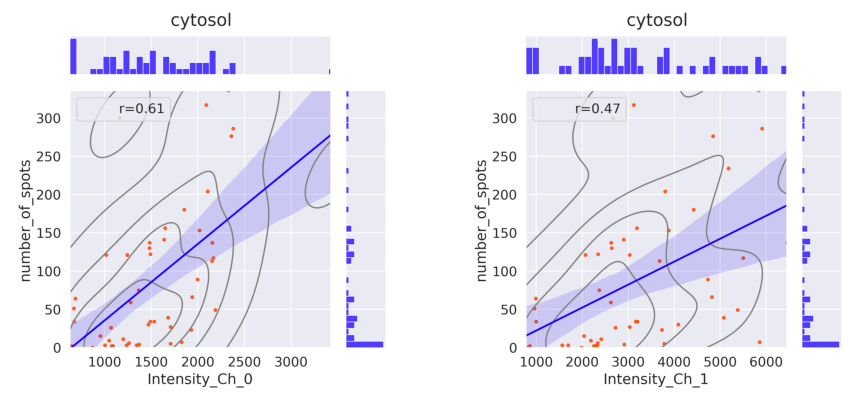

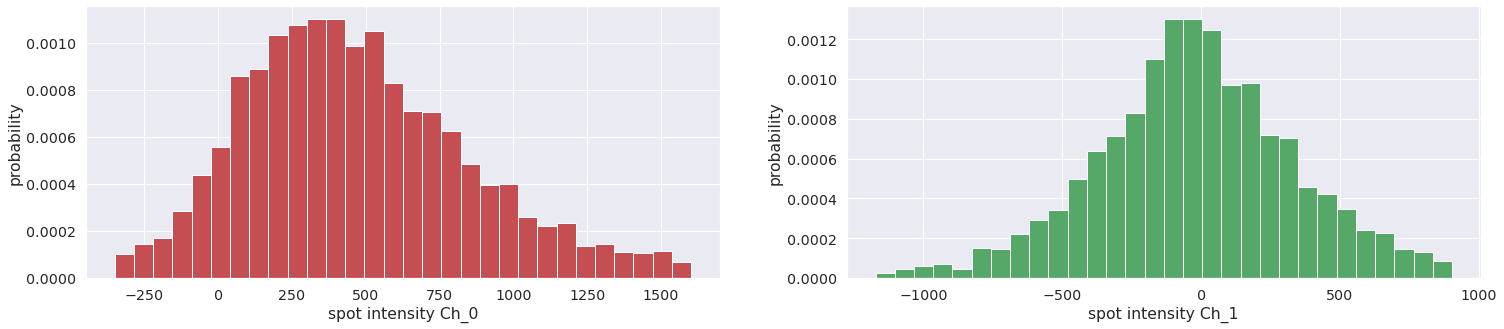

<Figure size 432x288 with 0 Axes>

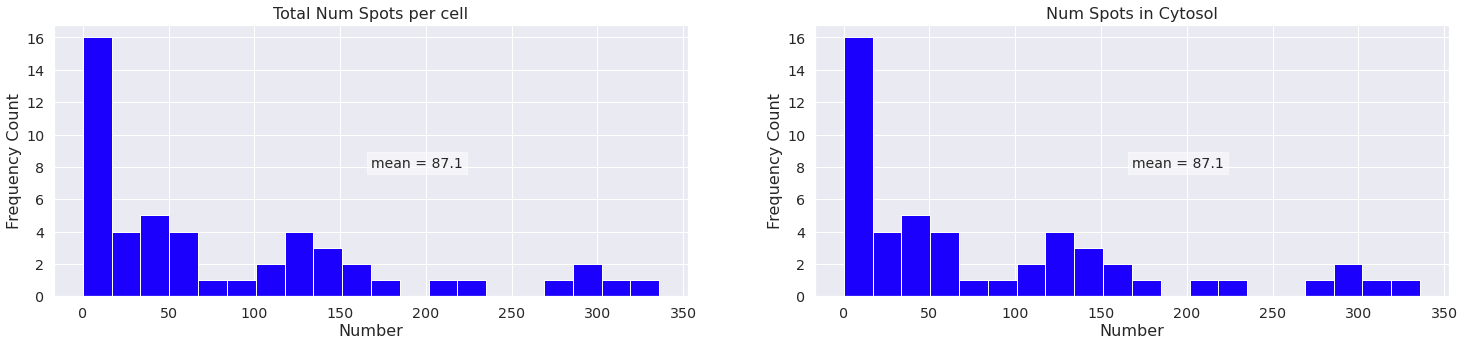

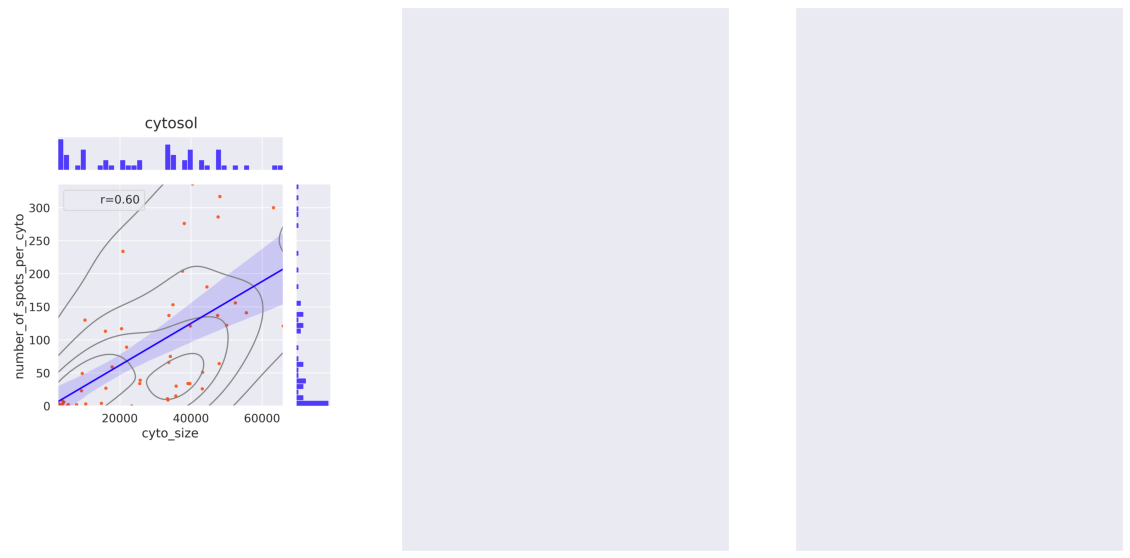

In [12]:
list_files_distributions = fa.Plots.plot_all_distributions(dataframe_FISH,channels_with_cytosol, channels_with_nucleus,channels_with_FISH,minimum_spots_cluster,output_identification_string )

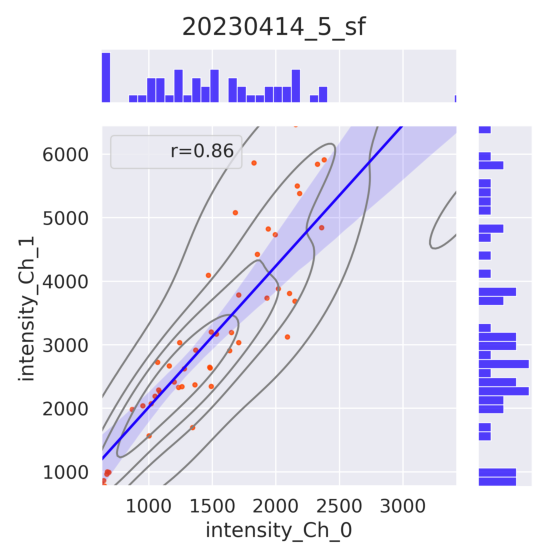

In [13]:
file_plots_bleed_thru = fa.Plots.plot_scatter_bleed_thru(dataframe_FISH, channels_with_cytosol, channels_with_nucleus,output_identification_string)

## Saving data

In [14]:
# Saving data and plots, and sending data to NAS
fa.Utilities.save_output_to_folder(output_identification_string, data_folder_path, list_files_distributions=list_files_distributions,
                                   file_plots_bleed_thru=file_plots_bleed_thru,channels_with_FISH=channels_with_FISH)

# sending data to NAS
analysis_folder_name, mask_dir_complete_name = fa.Utilities.sending_data_to_NAS(output_identification_string, data_folder_path, path_to_config_file, path_to_masks_dir, diameter_nucleus, diameter_cytosol, send_data_to_NAS, masks_dir)

# Moving the complete analysis folder to final analyses folder 
fa.Utilities.move_results_to_analyses_folder( output_identification_string, data_folder_path, mask_dir_complete_name, path_to_masks_dir, save_filtered_images, download_data_from_NAS )